### based on https://github.com/higgsfield/RL-Adventure and https://medium.com/swlh/introduction-to-reinforcement-learning-coding-sarsa-part-4-2d64d6e37617

In [1]:
%matplotlib inline
import collections
import cv2
import gym
import gzip
import matplotlib.pyplot as plot
import numpy as np
import random
import time
import torch as t
from IPython.display import clear_output

In [2]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not belive how complex the previous solution was."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype is not None:
            out = out.astype(dtype)
        return out

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Change image shape to CWH
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]))

    def observation(self, observation):
        return observation.transpose(2, 0, 1)
    
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = collections.deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0]*k, shp[1], shp[2]))

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(ResizeObservation, self).__init__(env)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0] // 2, shp[1] // 2, shp[2]))
        self.resize_to = (shp[1] // 2, shp[0] // 2)

    def observation(self, observation):
        return cv2.resize(observation, self.resize_to, interpolation=cv2.INTER_AREA)

env = gym.make('TennisDeterministic-v4')
env = ResizeObservation(env)
env = ImageToPyTorch(env)
env = FrameStack(env, 4)

In [3]:
USE_CUDA = t.cuda.is_available()# and False
device = t.device('cuda') if USE_CUDA else t.device('cpu')

In [4]:
class Replay(object):
    def __init__(self, maxlen):
        self.memory = np.empty(maxlen, dtype=np.object)
        self.index = 0
        self.count = 0

    def __len__(self):
        return self.count

    def _after_add(self):
        self.index = (self.index + 1) % len(self.memory)
        if self.count < len(self.memory):
            self.count += 1

    def add(self, state, action, next_state, reward, done):
        self.memory[self.index] = (state, action, next_state, reward, done)
        self._after_add()

    def add_with_context(self, context, state, action, next_state, reward, done):
        self.memory[self.index] = (context, state, action, next_state, reward, done)
        self._after_add()

    def _common_tensors(self, states, actions, next_states, rewards, masks):
        actions = t.LongTensor(actions).to(device)
        rewards = t.FloatTensor(rewards).to(device)
        masks = 1 - t.FloatTensor(masks).to(device)
        states = Replay.stack_states(states)
        next_states = Replay.stack_states(next_states)
        return states, actions, next_states, rewards, masks
        
    def sample(self, n):
        with t.no_grad():
            indices = np.random.randint(low=0, high=self.count, size=n)
            states, actions, next_states, rewards, masks = zip(*list(self.memory[indices]))
            return self._common_tensors(states, actions, next_states, rewards, masks)

    def sample_with_context(self, n):
        with t.no_grad():
            indices = np.random.randint(low=0, high=self.count, size=n)
            contexts, states, actions, next_states, rewards, masks = zip(*list(self.memory[indices]))
            states, actions, next_states, rewards, masks = self._common_tensors(states, actions, next_states, rewards, masks)
            contexts = t.cat(contexts)
            return contexts, states, actions, next_states, rewards, masks

    @staticmethod
    def stack_states(states):
        s = np.concatenate([np.expand_dims(x, 0) for x in states])
        return t.ByteTensor(s).to(device).float()

In [ ]:
class SlaveDuelingCnnDqn(t.nn.Module):
    def __init__(self, input_shape, n_out, n_orders):
        super().__init__()
        self.input_shape = input_shape
        self.cnn = t.nn.Sequential(
            t.nn.Conv2d(12, 64, kernel_size=8, stride=4),            t.nn.PReLU(),
            t.nn.Conv2d(64, 96, kernel_size=4, stride=2),            t.nn.PReLU(),
            t.nn.Conv2d(96, 128, kernel_size=3, stride=1),           t.nn.PReLU(),
        ) # -> 64 12 6
        self.adv = t.nn.Sequential(
            t.nn.Linear(self.feature_size() + n_orders, 512),        t.nn.PReLU(),
            t.nn.Linear(512, n_out)
        )
        self.val = t.nn.Sequential(
            t.nn.Linear(self.feature_size() + n_orders, 256),        t.nn.PReLU(),
            t.nn.Linear(256, 1)
        )

    def feature_size(self):
        return self.cnn(t.zeros(1, *self.input_shape)).view(1, -1).size(1)

    def forward(self, orders, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(0)
        p = self.cnn(x)
        p = p.view(p.size(0), -1)
        if len(orders.shape) < 2:
            orders = orders.unsqueeze(0)
        p = t.cat([p, orders], dim=1)
        adv = self.adv(p)
        val = self.val(p)
        return val + adv - adv.mean()

    def model_type(self):
        return 'slave-dueling-cnn-dqn'

class MasterDuelingCnnDqn(t.nn.Module):
    def __init__(self, input_shape, n_out):
        super().__init__()
        self.input_shape = input_shape
        self.cnn = t.nn.Sequential(
            t.nn.Conv2d(12, 32, kernel_size=8, stride=4),            t.nn.PReLU(),
            t.nn.Conv2d(32, 64, kernel_size=4, stride=2),            t.nn.PReLU(),
            t.nn.Conv2d(64, 64, kernel_size=3, stride=1),            t.nn.PReLU(),
        ) # -> 64 12 6
        self.adv = t.nn.Sequential(
            t.nn.Linear(self.feature_size(), 128),                   t.nn.PReLU(),
            t.nn.Linear(128, n_out)
        )
        self.val = t.nn.Sequential(
            t.nn.Linear(self.feature_size(), 64),                    t.nn.PReLU(),
            t.nn.Linear(64, 1)
        )

    def feature_size(self):
        return self.cnn(t.zeros(1, *self.input_shape)).view(1, -1).size(1)

    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(0)
        p = self.cnn(x)
        p = p.view(p.size(0), -1)
        adv = self.adv(p)
        val = self.val(p)
        return val + adv - adv.mean()

    def model_type(self):
        return 'master-dueling-cnn-dqn'

def build_slave(n_orders):
    return SlaveDuelingCnnDqn(env.observation_space.shape, env.action_space.n, n_orders).to(device)

def build_master(n_orders):
    return MasterDuelingCnnDqn(env.observation_space.shape, n_orders).to(device)

In [ ]:
def learn_on_batch(q_values, q_next_values, loss_fn, opt, actions, rewards, masks):
    global gamma
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    q_next_value = q_next_values.max(1).values
    
    target = rewards + gamma * masks * q_next_value
    loss = loss_fn(q_value, target.detach())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    return loss.item()

def learn_slave(model, target_model, loss_fn, opt, replay, batch_size):
    contexts, states, actions, next_states, rewards, masks = replay.sample_with_context(batch_size)
    q_values = model(contexts, states)
    q_next_values = target_model(contexts, next_states)
    return learn_on_batch(q_values, q_next_values, loss_fn, opt, actions, rewards, masks)

def learn_master(model, target_model, loss_fn, opt, replay, batch_size):
    states, actions, next_states, rewards, masks = replay.sample(batch_size)
    q_values = model(states)
    q_next_values = target_model(next_states)
    return learn_on_batch(q_values, q_next_values, loss_fn, opt, actions, rewards, masks)

In [ ]:
def reset_env(env):
    state = env.reset()
    if 'FIRE' in env.unwrapped.get_action_meanings():
        state, _, _, _ = env.step(env.unwrapped.get_action_meanings().index('FIRE'))
    return state

In [ ]:
DOUBLE_MODEL = True
N_MASTER_ORDERS = 8

master = build_master(N_MASTER_ORDERS)
if DOUBLE_MODEL:
    target_master = build_master(N_MASTER_ORDERS)
else:
    target_master = master
master_opt =  t.optim.Adam(master.parameters(), lr=1e-4)
master_loss_fn = t.nn.SmoothL1Loss()

slave = build_slave(N_MASTER_ORDERS)
if DOUBLE_MODEL:
    target_slave = build_slave(N_MASTER_ORDERS)
else:
    target_slave = slave
slave_opt =  t.optim.Adam(slave.parameters(), lr=1e-4)
slave_loss_fn = t.nn.SmoothL1Loss()

In [ ]:
def load(model):
    path = f'model-{model.model_type()}.gz'
    try:
        with gzip.open(path, 'rb') as f:
            model.load_state_dict(t.load(f))
            target_model.load_state_dict(model.state_dict())
            print(f'model weights loaded from {path}')
        return True
    except:
        print(f'didn\'t load model weights from {path}')
        return False

def save_weights(model):
    path = f'model-{model.model_type()}.gz'
    try:
        with gzip.open(path, 'wb') as f:
            t.save(model.state_dict(), f, pickle_protocol=4)
            print(f'model weights saved to {path}')
    except:
        print(f'didn\'t save model weights to {path}')

In [ ]:
slave_replay = Replay(1000000)
master_replay = Replay(100000)
all_rewards = collections.deque(maxlen=500)
game_steps = collections.deque(maxlen=500)
losses = collections.deque(maxlen=10000)
batch_size = 32
gamma = 0.99
episode, frame = 0, 0
eps = 1
eps_final = 0.01
eps_decay = np.exp(np.log(eps_final / eps) / 50000)

In [ ]:
def plot_state(msg):
    clear_output(False)
    plot.figure(figsize=(24,5))
    plot.subplot(141)
    plot.title('rewards (frame=%dk, %d episodes)' % (np.round(frame/1000), episode))
    no_last = lambda x: np.array(x)[:-1]
    plot.plot(no_last(all_rewards))
    plot.subplot(142)
    plot.title('game steps')
    plot.plot(no_last(game_steps))
    plot.subplot(143)
    plot.title('losses')
    plot.plot(losses)
    plot.subplot(144)
    plot.title('random screen')
    _, state, _, _, _, _ = slave_replay.sample_with_context(1)
    plot.imshow(state.squeeze(0)[-3:].permute(1, 2, 0).cpu().numpy() / 255)
    plot.show();
    print(msg)

In [ ]:
contexts = np.empty(N_MASTER_ORDERS, dtype=np.object)
for i in range(N_MASTER_ORDERS):
    o = t.zeros((1, N_MASTER_ORDERS), dtype=t.float32, device=device, requires_grad=False)
    o[0, i] = 1
    contexts[i] = o

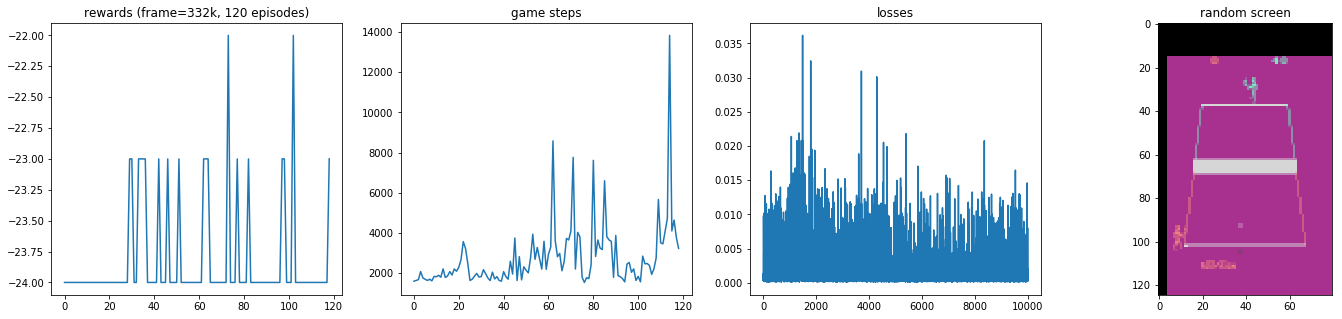

In [ ]:
while episode < 10000:
    episode += 1
    all_rewards.append(0)
    game_steps.append(0)
    state, done, zero_count = reset_env(env), False, 0
    
    while not done:
        master_state = state
        if random.random() > eps:
            master_action = master(t.FloatTensor(np.array(state)).to(device)).argmax().item()
        else:
            master_action = random.randint(0, N_MASTER_ORDERS - 1)
        context = contexts[master_action]
        master_reward = 0
        master_frame = frame + 20

        while (master_reward == 0) and (frame < master_frame) and not done:
            frame += 1
            eps = max(eps_final, eps * eps_decay)
            if random.random() > eps:
                action = slave(context, t.FloatTensor(np.array(state)).to(device)).argmax().item()
            else:
                action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)

            game_steps[-1] += 1
            all_rewards[-1] += reward

            if reward == 0:
                zero_count += 1
                slave_reward  = 0 if zero_count < 200 else -0.01
            else:
                zero_count = 0
                slave_reward = np.sign(reward)
                master_reward = reward

            slave_replay.add_with_context(context, state, action, next_state, slave_reward, done)
            state = next_state

            if len(slave_replay) > 50000:
                l = learn_slave(slave, target_slave, slave_loss_fn, slave_opt, slave_replay, batch_size)
                learn_master(master, target_master, master_loss_fn, master_opt, master_replay, batch_size)
                losses.append(l)

            if DOUBLE_MODEL and (frame % 1000 == 0):
                target_slave.load_state_dict(slave.state_dict())
                target_master.load_state_dict(master.state_dict())

            if frame % 1000 == 0:
                plot_state('')

            if frame % 100000 == 0:
                save_weights(master)
                save_weights(slave)

        master_replay.add(master_state, master_action, state, master_reward, done)

plot_state('finished')
save_weights(model)